# Explainability

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

Explainability in machine learning means that you can explain what happens in your model from input to output. It makes models transparent and solves the black box problem. Explainable AI (XAI) is the more formal way to describe this and applies to all artificial intelligence.

We can explain machine learning models numerically and graphically.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import shap
import warnings
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from matplotlib.pyplot import figure
from matplotlib import image as mpimg
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from category_encoders import JamesSteinEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [3]:
from preprocessing import *

In [4]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
def compute_auc(y, y_pred):

    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred, pos_label = 1)

    return metrics.auc(fpr, tpr)

In [6]:
def predict_proba(X):
    return clf.predict_proba(X)[:, 1]

In [7]:
!pip install -q xgboost

In [8]:
start = time.time()

# 1. Train the model

In [9]:
df = pd.read_csv('credit_risk.csv')

In [10]:
cat_str = ['person_home_ownership', 'loan_intent']
cat_oh = ['cb_person_default_on_file', 'loan_grade']

num_mean = ['person_age', 'person_income', 'loan_percent_income']
num_zero = ['cb_person_cred_hist_length']

num_mean_nan = ['loan_int_rate', 'person_emp_length']
num_zero_nan = ['loan_amnt']

X_cols = cat_str + cat_oh + num_mean + num_zero + num_mean_nan + num_zero_nan

label = 'loan_status'

In [11]:
features_dict = {
    'cat_str': cat_str,
    'cat_oh': cat_oh,
    'num_mean': num_mean,
    'num_zero': num_zero,
    'num_mean_nan': num_mean_nan,
    'num_zero_nan': num_zero_nan
}

In [12]:
X = df[X_cols].copy()
y = df[label].copy()

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.40, random_state = 10)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 10)

In [14]:
transformers_pre = get_fit_transfomers(features_dict, X_train, y_train)

In [15]:
y_train = y_train.reset_index()
y_train = y_train.drop(columns = ['index'])

y_val = y_val.reset_index()
y_val = y_val.drop(columns = ['index'])

y_test = y_test.reset_index()
y_test = y_test.drop(columns = ['index'])

In [16]:
X_train = transform_datasets(transformers_pre, features_dict, X_train)

X_val = transform_datasets(transformers_pre, features_dict, X_val)

X_test = transform_datasets(transformers_pre, features_dict, X_test)

In [17]:
clf = XGBClassifier(n_estimators = 60, max_depth = 7)

In [18]:
clf = clf.fit(X_train, y_train)

In [19]:
y_train_pred = clf.predict_proba(X_train)[:, 1]

y_val_pred = clf.predict_proba(X_val)[:, 1]

y_test_pred = clf.predict_proba(X_test)[:, 1]

In [20]:
y_train_pred = (y_train_pred >= 0.2)*1

y_val_pred = (y_val_pred >= 0.2)*1

y_test_pred = (y_test_pred >= 0.2)*1

In [21]:
r_train = recall_score(y_train, y_train_pred)

r_val = recall_score(y_val, y_val_pred)

r_test = recall_score(y_test, y_test_pred)

In [22]:
print('Recall Train:', round(r_train*100, 2))

print('Recall Val:', round(r_val*100, 2))

print('Recall Test:', round(r_test*100, 2))

Recall Train: 93.49
Recall Val: 83.97
Recall Test: 85.3


# 2. Numerical Explainability

In [23]:
y_train_pred = clf.predict_proba(X_train)[:, 1]

y_val_pred = clf.predict_proba(X_val)[:, 1]

y_test_pred = clf.predict_proba(X_test)[:, 1]

### i. LIME

Local Interpretable Model-agnostic Explanations (LIME for short). Instead of providing a global understanding of the model on the entire dataset, LIME focuses on explaining the model’s prediction for individual instances.

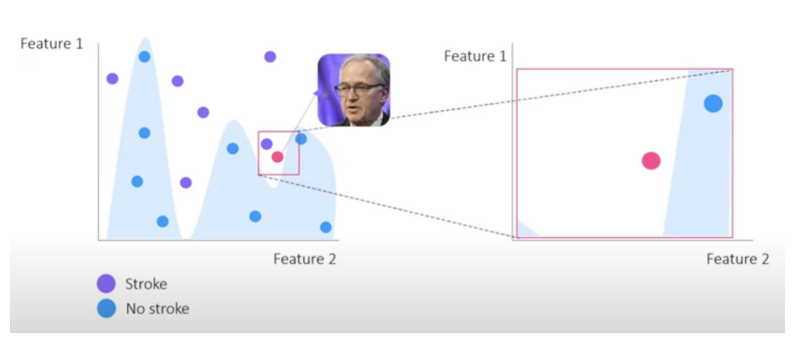

In [24]:
display_img('LIME.png', 10, 10)

The main idea is to perturb the input and see how the predictions change, and then generate an explanation by approximating the underlying model by an interpretable one (such as a linear model with only a few non-zero coefficients).

In [25]:
explainer = LimeTabularExplainer(X_train.values, feature_names = X_train.columns, class_names = [label], verbose = True, mode = 'regression')

In [26]:
i = 0
exp = explainer.explain_instance(X_test.values[i], predict_proba, num_features = 10)

Intercept 0.7284506882646877
Prediction_local [0.66426722]
Right: 0.43228242


In [27]:
print('Instance:', i)
print('Prediction:', y_test_pred[i])
exp.show_in_notebook(show_table = True)

Instance: 0
Prediction: 0.43228242


### ii. SHAP Values

The main idea of SHAP values is try to explain the contribution of every feature on the result of a model.

Consider "m" examples and "n" features, then:

$ \hat{y}^{(i)} = \sum_{k=1}^n \phi^{(i)}_k + \phi_0 \ \forall i \in \lbrace 1, ..., m \rbrace $

$ \textbf{Example:} $

Consider the model predict the probability of someone fall hospitalized and the next two features:

$ X_1 $ = The person was hospitalized in the previous year.

$ X_2 $ = The person visited the emergency room in the past year.

Consider the probability of someone fall hospitalized is $ f(X) = f(X_1, X_2) $.

We pick someone which probability is $ 27 \% $ and $ X_1 = 1, X_2 = 1 $ then we can do the next analysis:

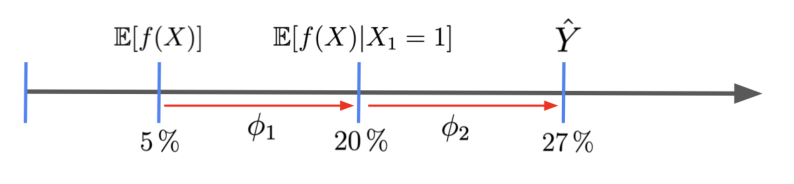

In [28]:
display_img('SHAP_Values.png', 10, 10)

$ \phi_1' = 20 \% - 5 \% = 15 \% \Rightarrow \boxed{\phi_1' = 15 \% } $

$ \phi_2' = 27 \% - 20 \% = 7 \% \Rightarrow \boxed{\phi_2' = 7 \% } $

What happen if we change the order of the features in the analysis?

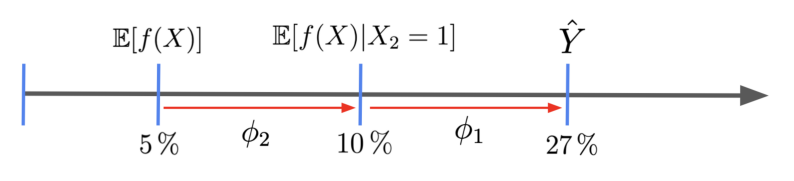

In [29]:
display_img('SHAP_Values_2.png', 10, 10)

$ \phi_2'' = 10 \% - 5 \% = 5 \% \Rightarrow \boxed{\phi_2'' = 5 \% } $

$ \phi_1'' = 27 \% - 10 \% = 17 \% \Rightarrow \boxed{\phi_1'' = 17 \% } $

As you can see the order matter and all the possible orders to $n$ features is $ n !\ $.

SHAP values optimize the compute of this values.

$ \textbf{Notes:} $

* The importance of the feature $j$ is: $ I_j = \frac{1}{m} \sum_{k=1}^m |\phi_j^{(k)}| $

* The relative importance of the feature $j$ is: $ \cfrac{I_j}{\sum_{t=1}^n I_t} $

In [30]:
explainer = shap.TreeExplainer(clf)

In [31]:
shap_values = explainer.shap_values(X_test)

In [32]:
df_shap_values = pd.DataFrame(shap_values)
df_shap_values.columns = X_test.columns

In [33]:
df_shap_values.head()

,person_home_ownership,loan_intent,cb_person_default_on_file_N,cb_person_default_on_file_Y,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,...,person_age,person_income,loan_percent_income,cb_person_cred_hist_length,loan_int_rate,person_emp_length,indic_loan_int_rate,indic_person_emp_length,loan_amnt,indic_loan_amnt
0,0.390933,-0.831136,0.018094,0.0,0.088211,0.080632,0.156027,0.676055,-0.013612,0.005990,...,0.086408,0.391168,-0.261608,0.129140,1.373888,-0.683494,-0.000447,-0.023035,-0.081806,0.0
1,-4.236527,0.234173,0.000715,0.0,0.020885,-0.081550,0.061019,-0.022230,-0.201229,-0.040629,...,0.152583,-0.311711,-0.342688,0.043277,-0.587236,-0.096033,-0.001347,-0.004496,-0.136765,0.0
2,-4.524281,0.610582,0.043921,0.0,0.024201,-0.103360,0.037392,-0.003135,-0.198354,-0.045328,...,-0.453414,0.989158,-0.212142,-0.058786,-0.564186,0.053380,-0.000991,-0.006210,-0.089297,0.0
3,1.998626,0.091783,-0.007523,0.0,-0.264413,0.022903,0.062249,-0.101702,-0.053315,-0.005861,...,-0.249477,0.613780,4.235503,-0.230545,-0.590473,0.265722,-0.001802,-0.008522,0.129486,0.0
4,-0.107748,-0.343614,-0.000179,0.0,-0.525610,0.064294,0.056504,-0.029080,-0.023003,-0.005747,...,0.043204,1.475620,-0.328708,0.008826,-0.450407,0.119002,-0.000034,-0.020731,-0.019850,0.0


**a. Importance of variables**

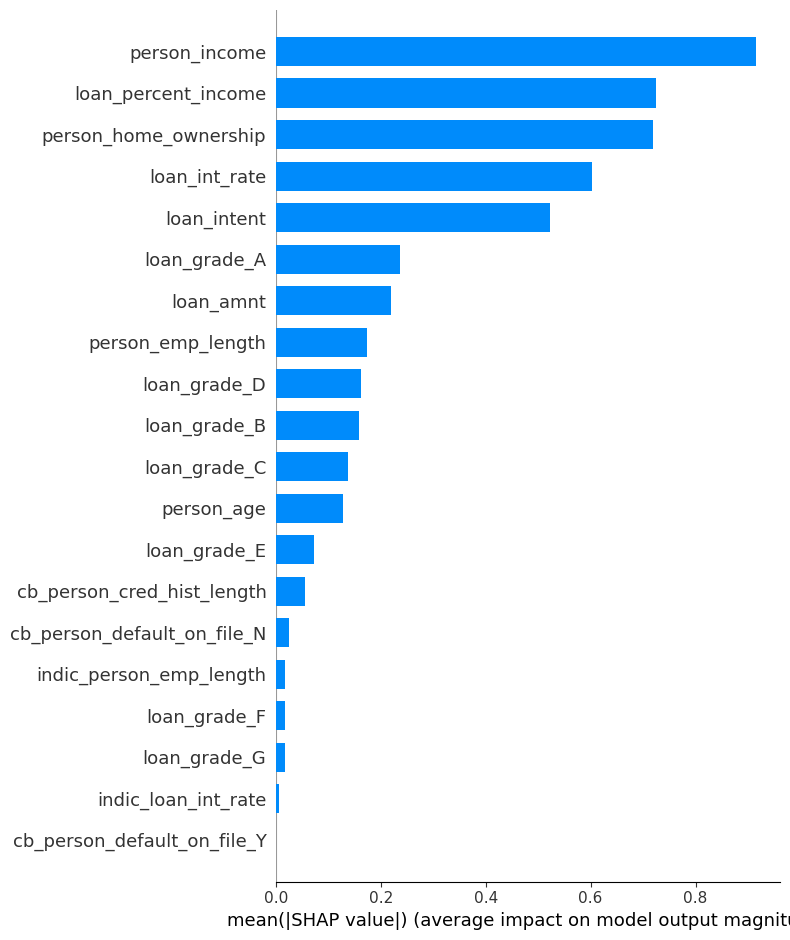

In [34]:
shap.summary_plot(shap_values, X_test, plot_type = "bar")

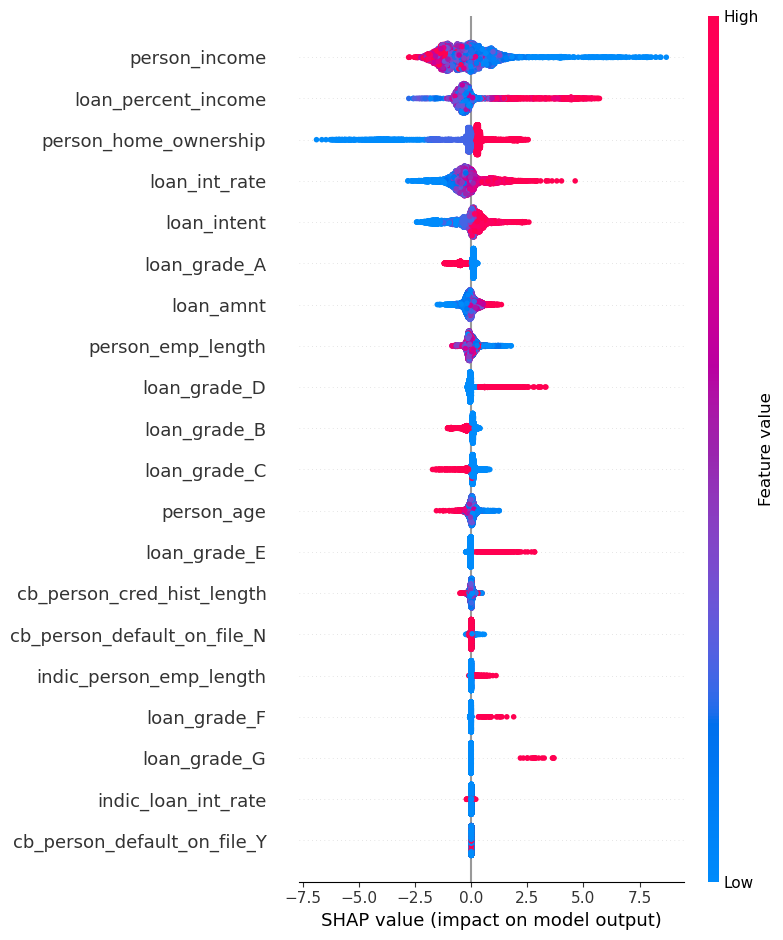

In [35]:
shap.summary_plot(shap_values, X_test)

In [36]:
df_shap_values.sum(axis = 0)

person_home_ownership          -981.814331
loan_intent                    -573.098450
cb_person_default_on_file_N     -28.650131
cb_person_default_on_file_Y       0.000000
loan_grade_A                   -734.392517
loan_grade_B                   -274.952942
loan_grade_C                    228.049789
loan_grade_D                    393.276794
loan_grade_E                    -20.066067
loan_grade_F                    -46.153004
loan_grade_G                      7.018280
person_age                       14.098086
person_income                  -862.043884
loan_percent_income             698.048218
cb_person_cred_hist_length      -31.393900
loan_int_rate                 -1209.721313
person_emp_length                58.899399
indic_loan_int_rate              -5.267166
indic_person_emp_length          -4.458262
loan_amnt                      -199.705658
indic_loan_amnt                   0.000000
dtype: float32

**b. Analysis**

In [37]:
df_shap_values['partial_sum_SHAP'] = df_shap_values.sum(axis = 1)

In [38]:
df_shap_values = df_shap_values[['partial_sum_SHAP']]

In [39]:
df_shap_values['prob_model'] = y_test_pred

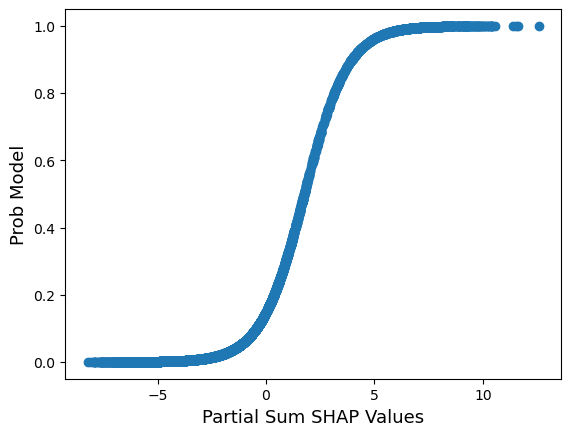

In [40]:
plt.scatter(df_shap_values['partial_sum_SHAP'], df_shap_values['prob_model'])
plt.xlabel('Partial Sum SHAP Values', fontsize = 13)
plt.ylabel('Prob Model', fontsize = 13)
plt.show()

In [41]:
df_shap_values['prob_model_logit'] = - np.log((1/df_shap_values['prob_model']) - 1)

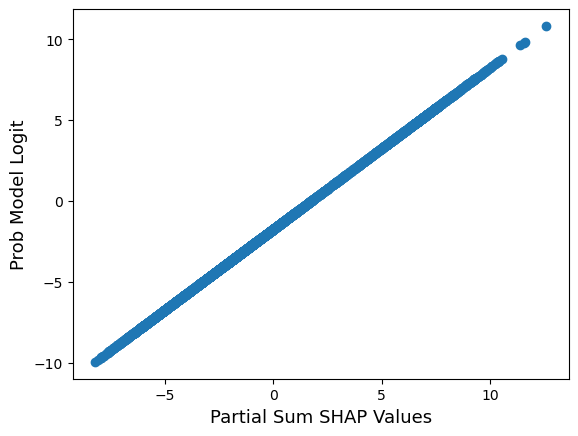

In [42]:
plt.scatter(df_shap_values['partial_sum_SHAP'], df_shap_values['prob_model_logit'])
plt.xlabel('Partial Sum SHAP Values', fontsize = 13)
plt.ylabel('Prob Model Logit', fontsize = 13)
plt.show()

In [43]:
from sklearn.linear_model import LinearRegression

In [44]:
reg = LinearRegression().fit(df_shap_values[['partial_sum_SHAP']], df_shap_values['prob_model_logit'])

In [45]:
alpha = reg.coef_[0]
beta = reg.intercept_

In [46]:
alpha, beta

(0.99999976, -1.7565125)

In [47]:
df_shap_values['estimation_prob'] = 1/(1 + np.exp(-(alpha*df_shap_values['partial_sum_SHAP'] + beta)))

In [48]:
abs(df_shap_values['estimation_prob'] - df_shap_values['prob_model']).max()

4.76837158203125e-07

**Comments:** As you can see the "SHAP Values" algorithm first apply logit function to the probability of the model and then compute the "SHAP Values".

# 3. Graphical Explainability

### i. SHAP Values (Dependence Plot)

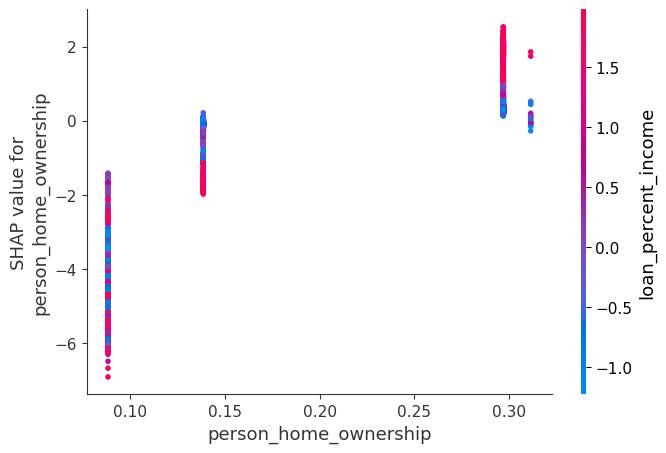

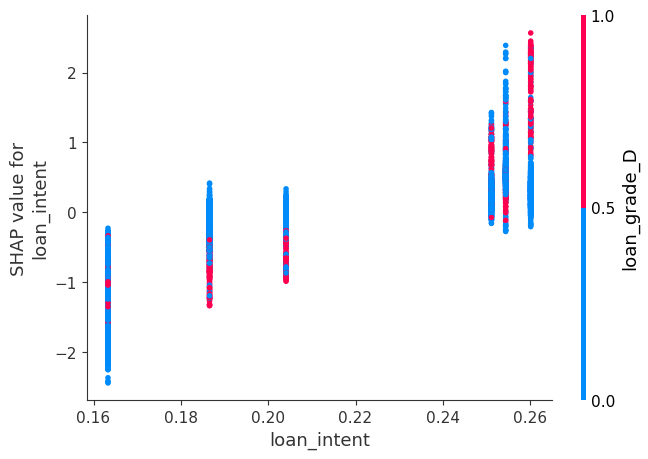

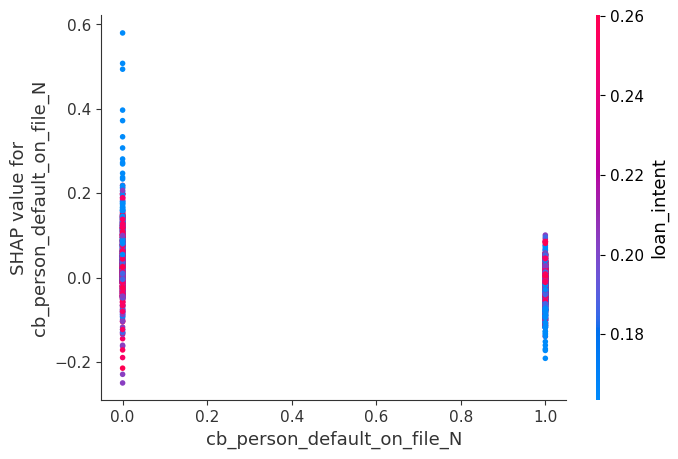

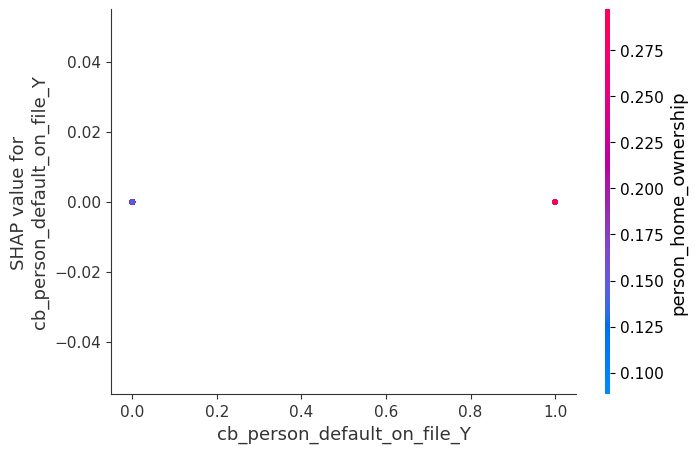

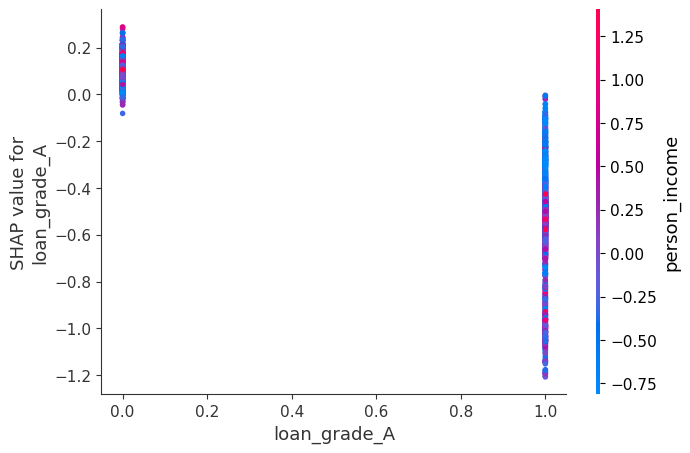

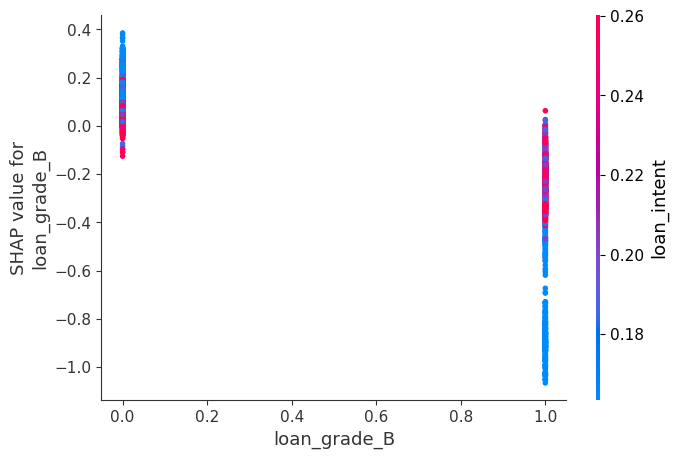

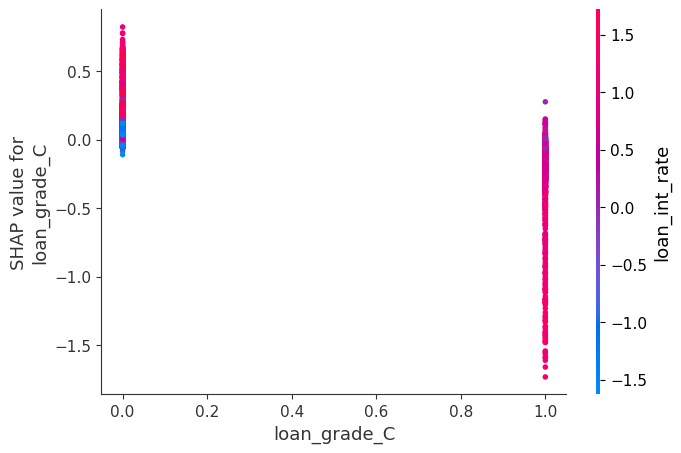

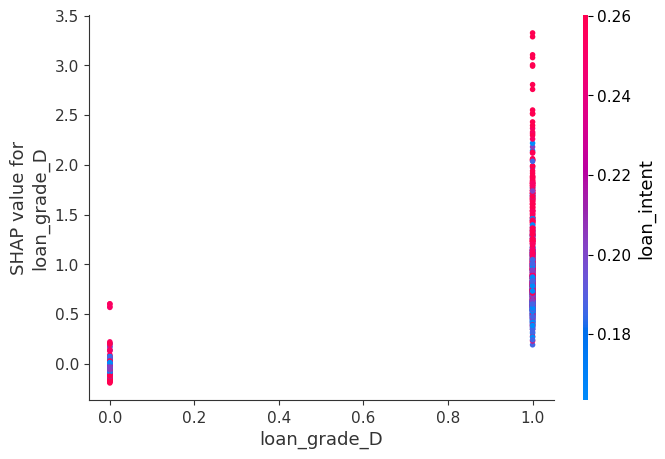

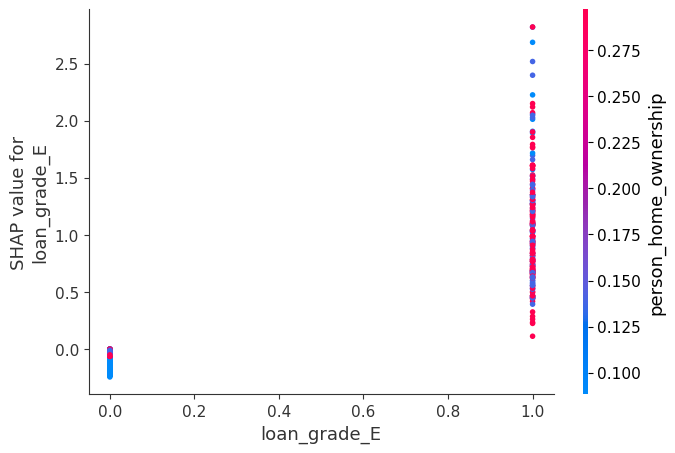

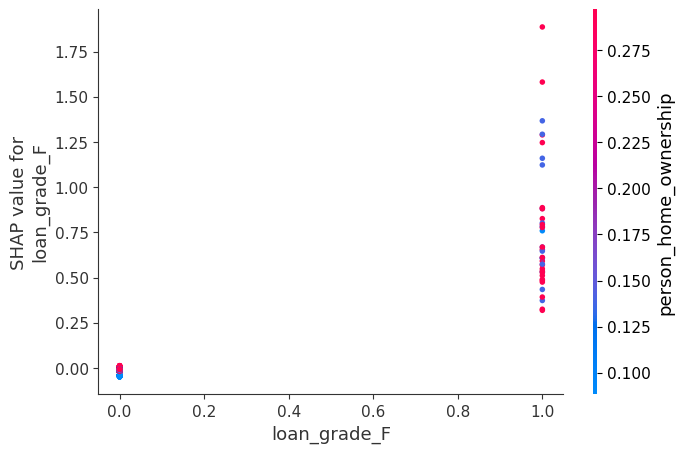

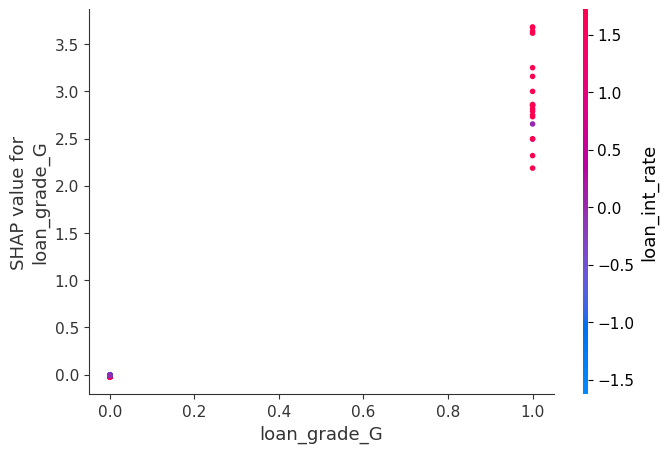

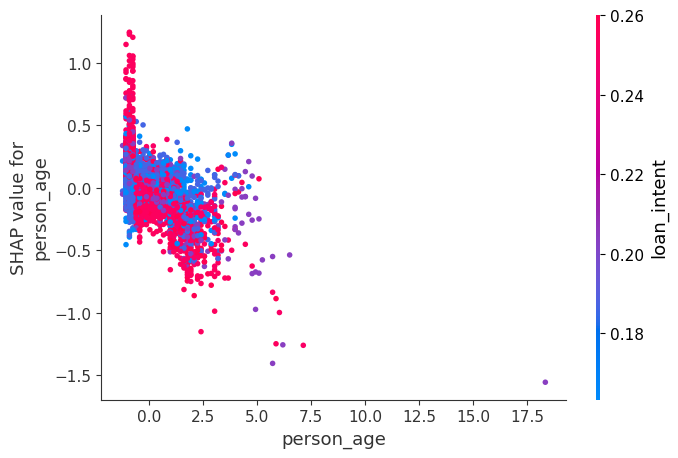

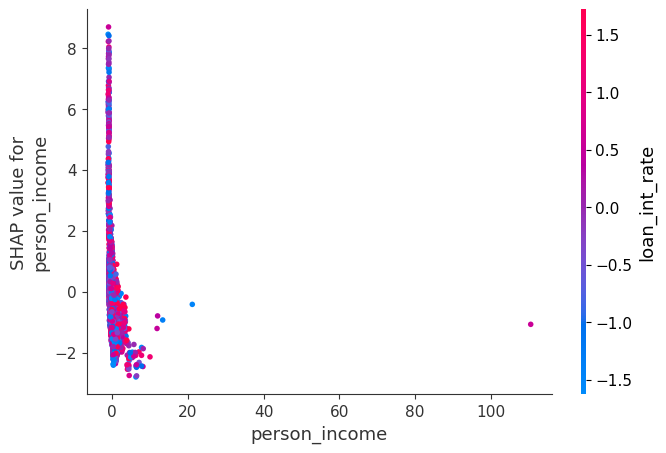

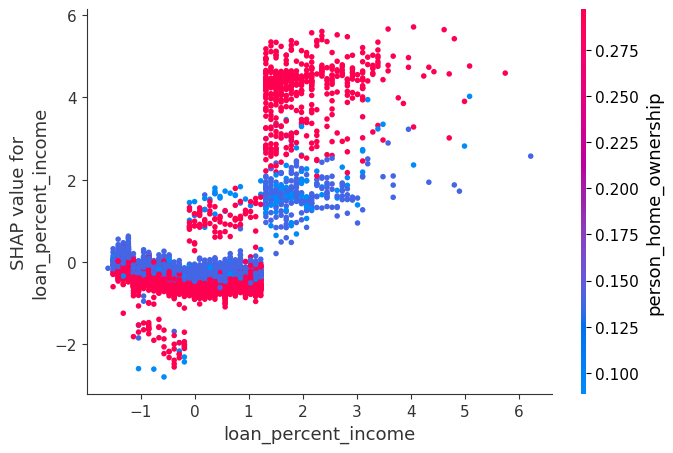

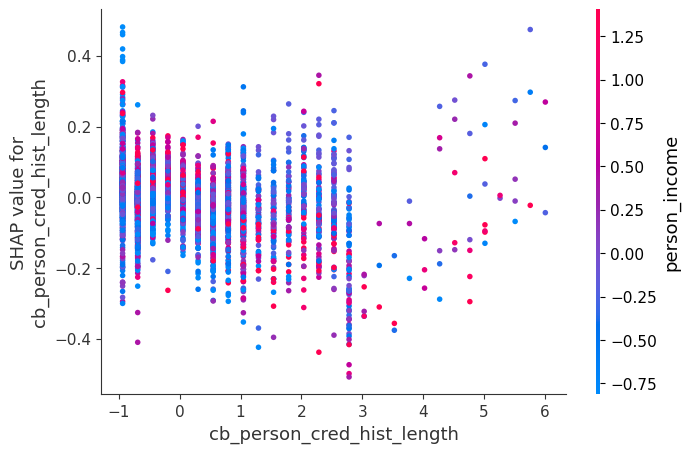

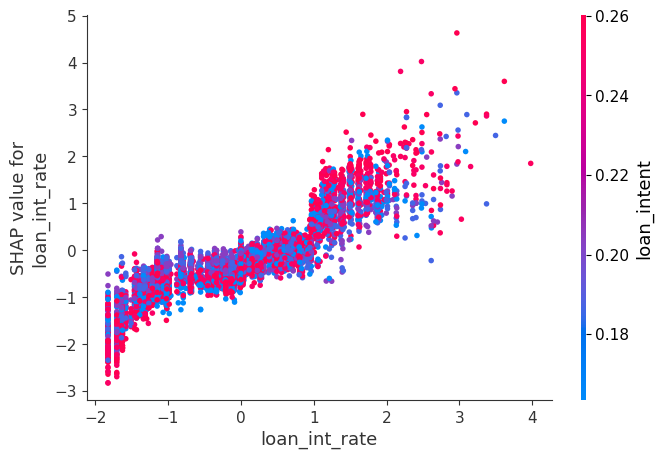

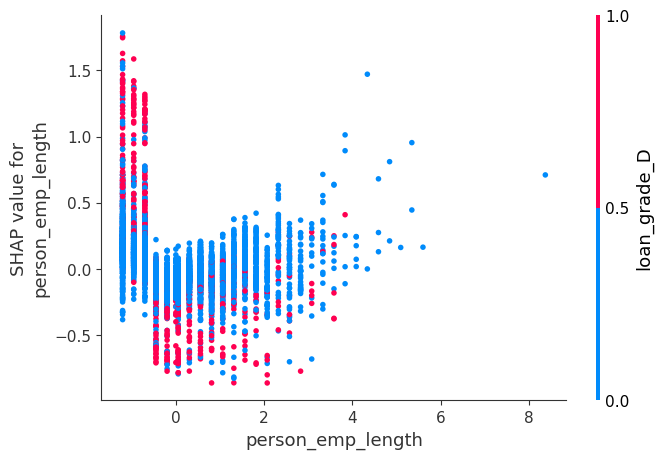

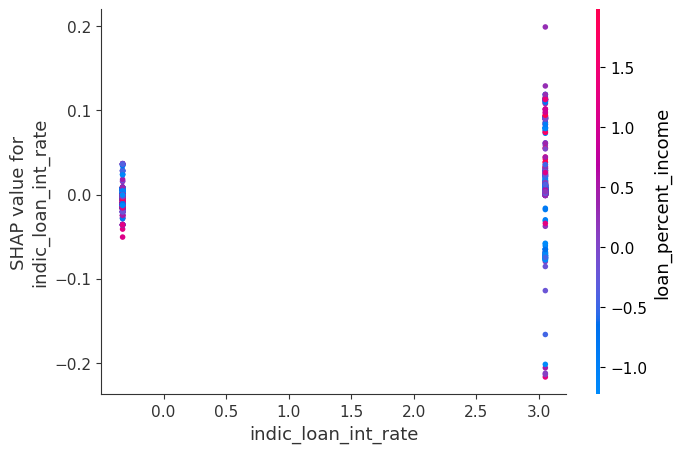

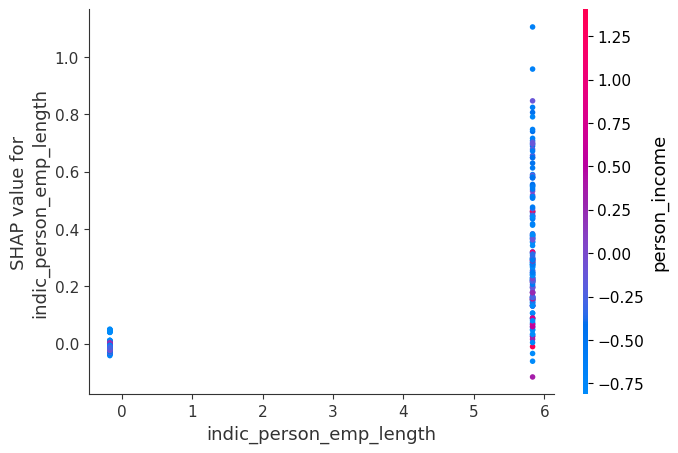

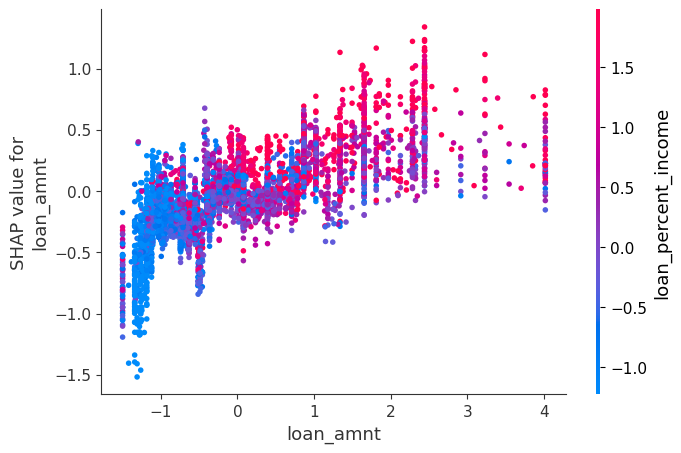

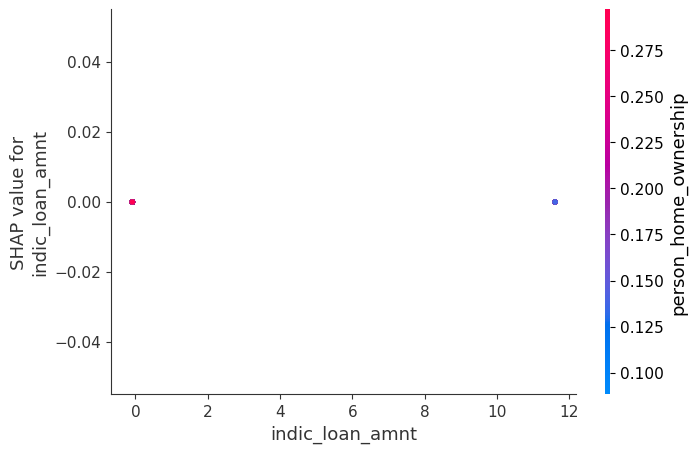

In [49]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_test)

### ii. Partial Dependence Plot

Consider the $ X_S $ features of interest and $ X_C $ its complement then:

$ p_D(X_S) = \mathbb{E}_{X_C}[f(X_S, X_C)] = \int f(X_S, X_C) \cdot p(X_C) dX_C $

In [50]:
df_pd_test = X_test.copy()
df_pd_test['prob'] = y_test_pred

In [51]:
df_pd_test = df_pd_test[['loan_amnt', 'prob']]

In [52]:
trh = 0.25

In [53]:
df_pd_test['loan_amnt'] = (df_pd_test['loan_amnt']/trh).apply(int)*trh

In [54]:
df_pd_test_gb = df_pd_test.groupby(by = ['loan_amnt'], as_index = False).mean()

In [55]:
df_pd_test_gb = df_pd_test_gb[(-1.96 <= df_pd_test_gb['loan_amnt']) & (df_pd_test_gb['loan_amnt'] <= 1.96)]

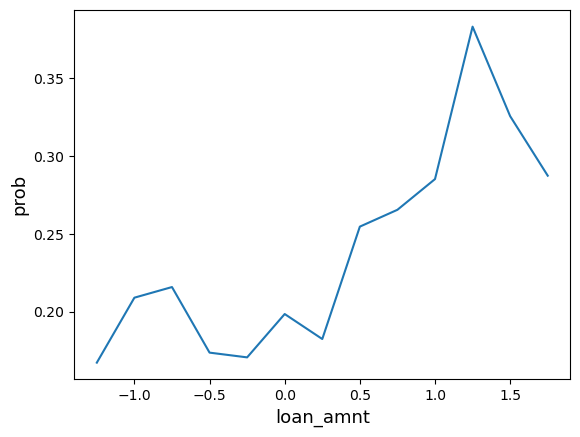

In [56]:
plt.plot(df_pd_test_gb['loan_amnt'], df_pd_test_gb['prob'])
plt.xlabel('loan_amnt', fontsize = 13)
plt.ylabel('prob', fontsize = 13)
plt.show()

### Time of execution

In [57]:
end = time.time()

In [58]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 0 minutes and 7 seconds.
